In [0]:
import cv2
import imutils
from google.colab.patches import cv2_imshow
from skimage.filters import threshold_local


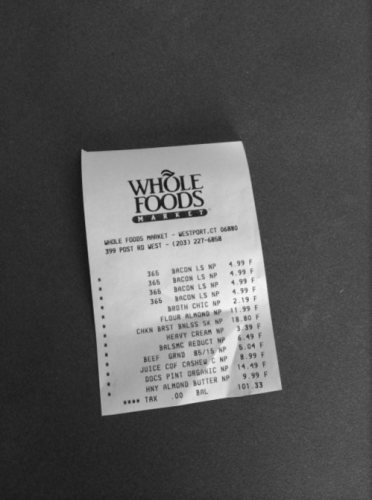

In [0]:
path='/content/receipt-scanned.jpg'
image=cv2.imread(path)

orig=image.copy()
image=imutils.resize(image,height=500)
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

## STEP:1 Edge Detection

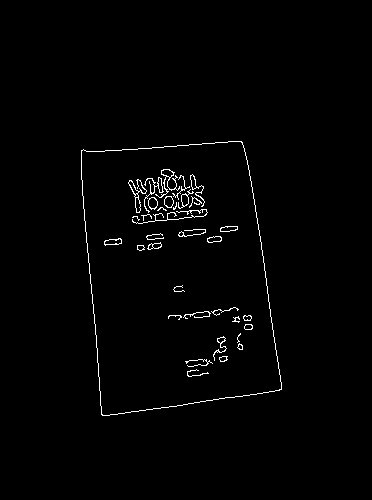

In [0]:
ratio = image.shape[0] / 500.0
gray=cv2.GaussianBlur(gray,(7,7),0)
edged=cv2.Canny(gray,80,200)
cv2_imshow(edged)

## STEP:2 Finding contours

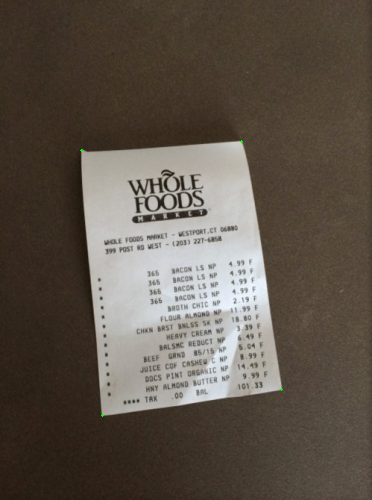

In [0]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
# loop over the contours
for c in cnts:
	# approximate the contour
  perimeter = cv2.arcLength(closed=True,curve=c)
  
  approx = cv2.approxPolyDP(c, 0.02 * perimeter, closed=True)
  

  if len(approx)==4:
    scanner=approx
    break

cv2.drawContours(image,scanner,-1,(0,255,0),2)
cv2_imshow(image)
  


In [0]:
scanner=scanner.reshape(4,2)

In [0]:
import numpy as np
def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):

	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

## STEP 3: Apply a Perspective Transform & Threshold

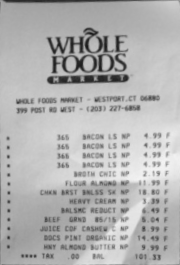

In [0]:
raect=order_points(scanner)
warped=four_point_transform(image,raect)

warped=cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)
cv2_imshow(warped)